<a href="https://colab.research.google.com/github/natrask/ENM5320/blob/main/Code/Trainable_Nonlinear_Stencil.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Coding Lecture - Building an architecture for nonlinear stencil learning

## First, modifying the previous code

To start with we will modify the code we played with in the previous homework to build up nonlinear stencils. I've copied and pasted below:

In [2]:

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Define the model
class FiniteDifferenceOperator(nn.Module):
    def __init__(self,Nleft,Nright):
        super(FiniteDifferenceOperator, self).__init__()
        # Number of total nodes in finite difference stencils
        self.Nstencil = Nleft + Nright + 1
        self.Nleft = Nleft
        self.Nright = Nright

        # Initialize with random coefficients
        self.stencil = torch.nn.Parameter(torch.randn(self.Nstencil))
        # self.stencil = torch.from_numpy((0.5/dx)*np.array([1,0,-1]))


    def forward(self, x):
        # Apply the finite difference stencil to the gridfunction x, assuming periodic BC
        N_nodes = x.shape[0]
        f_out = torch.zeros_like(x)
        for i in range(N_nodes):
          for jj in range(self.Nstencil):
            j = jj - self.Nleft
            j_withbc = (i+j)%(N_nodes-1)
            f_out[i] += self.stencil[jj]*x[j_withbc]

        return f_out

I'm going to modify the forward pass so that it functions identically, but uses syntax that will be better for nonlinear terms.

In [ ]:
# Define the model
class FiniteDifferenceOperator(nn.Module):
    def __init__(self,Nleft,Nright,num_layers, hidden_dim):
        super(FiniteDifferenceOperator, self).__init__()
        # Number of total nodes in finite difference stencils
        self.Nstencil = Nleft + Nright + 1
        self.Nleft = Nleft
        self.Nright = Nright
        self.stencil = torch.nn.Parameter(torch.randn(self.Nstencil))
    def forward(self, x, h):
        # Apply the finite difference stencil to the gridfunction x, assuming periodic BC
        N_nodes = x.shape[0]
        f_out = torch.zeros_like(x)
        for i in range(N_nodes):
          # Wrap indices periodically using the modulo operator (%)
          indices = [(i + j - self.Nleft) % (N_nodes-1) for j in range(self.Nstencil)]

          # Grab solution at indices
          xstencil = x[indices]

          # Apply learned stencil to xstencil
          f_out[i] = torch.sum(self.stencil * xstencil)

        # Return stencil applied to current state consisting of nonlinearity and stabilizing diffusion
        return f_out

Next we will take that code and modify it so that we can enhance model stability via artificial viscosity. Remember from our analysis in class that we showed a nonlinear problem of the form
$$\mathbf{A} x + \epsilon \mathcal{N}[x] = f$$
has a solution if $A$ is invertible and $\mathcal{N}$ is Lipschitz, and the operator norm of $A$ is large relative to the Lipschitz constant of $\mathcal{N}$.

Motivated by this, we will first add a hardcoded diffusion component to the stencil:
$$\mathcal{D} u = D_+ D_- u = \frac{1}{h^2}\left[ u_{j+1} - 2 u_j + u_{j-1}\right]$$

We should stress that this analysis only tells us that we can solve the nonlinear problem at each step - it doesn't tell us anything about the stability of the solution as it evolves in time.

In [ ]:
# Define the model
class FiniteDifferenceOperator(nn.Module):
    def __init__(self,Nleft,Nright,num_layers, hidden_dim):
        super(FiniteDifferenceOperator, self).__init__()
        # Number of total nodes in finite difference stencils
        self.Nstencil = Nleft + Nright + 1
        self.Nleft = Nleft
        self.Nright = Nright

        # The learnable part of the stencil
        self.stencil = torch.nn.Parameter(torch.randn(self.Nstencil))
        # The diffusion parameter. To enforce positivity, we evolve the log of the magnitude
        self.logstabilizer = torch.nn.Parameter(torch.tensor(0.0, dtype=torch.float64))


    def forward(self, x, h):
        # Apply the finite difference stencil to the gridfunction x, assuming periodic BC
        N_nodes = x.shape[0]
        f_out = torch.zeros_like(x)
        for i in range(N_nodes):
          # Wrap indices periodically using the modulo operator (%)
          indices = [(i + j - self.Nleft) % (N_nodes-1) for j in range(self.Nstencil)]

          # Grab solution at indices
          xstencil = x[indices]

          # Hard coded diffusion operator
          D2x = h**(-2)*(x[(i-1)%(N_nodes-1)] - 2*x[i] + x[(i+1)%(N_nodes-1)])

          # Apply learned stencil to xstencil, including the viscosity term
          f_out[i] = torch.sum(self.stencil * xstencil) + torch.exp(self.logstabilizer)*D2x

        # Return stencil applied to current state consisting of nonlinearity and stabilizing diffusion
        return f_out

Finally, we can modify the stencil so that it can depend nonlinearly upon the solutions nodal values.

In [ ]:
# Define the model
class FiniteDifferenceOperator(nn.Module):
    def __init__(self,Nleft,Nright,num_layers, hidden_dim):
        super(FiniteDifferenceOperator, self).__init__()
        # Number of total nodes in finite difference stencils
        self.Nstencil = Nleft + Nright + 1
        self.Nleft = Nleft
        self.Nright = Nright

        # The learnable part of the stencil
        self.stencil = torch.nn.Parameter(torch.randn(self.Nstencil))
        # The diffusion parameter. To enforce positivity, we evolve the log of the magnitude
        self.logstabilizer = torch.nn.Parameter(torch.tensor(0.0, dtype=torch.float64))

        # Construct nonlinear network
        # -- The first layer scales up from Nstencil point to a hidden dimension (Input layer)
        # -- Next, hidden layers repeatedly alternate between linear transforms and nonlinear activations (Hidden layers)
        # -- Finally, a linear layer maps back down to Nstencil outputs
        # We'll use skip connections in the hidden layer to improve numerical stability

        layers = []

        # Input layer
        layers.append(nn.Linear(self.Nstencil, hidden_dim, dtype=torch.float64))
        layers.append(nn.Tanh())  # Activation function

        # Hidden layers
        # First make a list of hidden layers
        hiddenlayers = []
        for _ in range(num_layers):
            block = nn.Sequential(
                nn.Linear(hidden_dim, hidden_dim, dtype=torch.float64),
                nn.Tanh()
            )
            hiddenlayers.append(block)

        # Next apply skip connections
        class SkipConnectionBlock(nn.Module):
            def __init__(self, block):
                super(SkipConnectionBlock, self).__init__()
                self.block = block

            def forward(self, x):
                return x + self.block(x)

        skip_connection_layers = [SkipConnectionBlock(block) for block in hiddenlayers]
        hidden_layers = nn.Sequential(*skip_connection_layers)
        layers.extend(hidden_layers)

        # Output layer
        output_layer = nn.Linear(hidden_dim, self.Nstencil, dtype=torch.float64)
        output_layer.weight.data.fill_(0.0)  # Set weights to zero
        output_layer.bias.data.fill_(0.0)  # Set bias to zero (if any)
        layers.append(output_layer)

        self.nonlinear_network = nn.Sequential(*layers)

    def forward(self, x, h):
        # Apply the finite difference stencil to the gridfunction x, assuming periodic BC
        N_nodes = x.shape[0]
        f_out = torch.zeros_like(x)
        for i in range(N_nodes):
          # Wrap indices periodically using the modulo operator (%)
          indices = [(i + j - self.Nleft) % (N_nodes-1) for j in range(self.Nstencil)]

          # Grab solution at indices
          xstencil = x[indices]

          # Hard coded diffusion operator
          D2x = h**(-2)*(x[(i-1)%(N_nodes-1)] - 2*x[i] + x[(i+1)%(N_nodes-1)])

          # Apply neural network to xstencil
          nonlinear_output = self.nonlinear_network(xstencil)

          # Apply learned stencil to xstencil, including the viscosity term
          # f_out[i] = torch.sum(self.stencil * xstencil) + torch.exp(self.logstabilizer)*D2x
          f_out[i] = torch.sum(nonlinear_output * xstencil) + torch.exp(self.logstabilizer)*D2x

        # Return stencil applied to current state consisting of nonlinearity and stabilizing diffusion
        return f_out

Let's train this model up and see how well it performs...

In [ ]:
# Parameters
L = 2.0*np.pi  # Length of the domain
T = np.pi   # Total time
nx = 50  # Number of spatial points
nt = 100  # Number of time steps

# Discretization
dx = L / nx
dt = T / nt
x = torch.from_numpy(np.linspace(0, L, nx))
t = torch.from_numpy(np.linspace(0, T, nt))
Dx = FiniteDifferenceOperator(1,1,2,25)  # Finite difference operator w a neighbor on either side

# Define the optimizer so that it optmizes over stencil parameters
optimizer = optim.Adam(Dx.parameters(), lr=0.01)

# Define a single mode
def getData(x,k):
  return torch.sin(k*x)
def getLabel(x,k):
  return (getData(x-dt,k)-getData(x,k))/dt

# Define the optimizer so that it optmizes over stencil parameters
optimizer = optim.Adam(Dx.parameters(), lr=0.005)

num_epochs = 5001
for epoch in range(num_epochs):

    # Clear gradients
    optimizer.zero_grad()

    # Pick a random wavenumber
    k = 1
    un = getData(x,k)
    Lun = getLabel(x,k)

    # Add small gaussian noise to data
    Lun = Lun + 0.01*torch.randn(Lun.shape)

    dudt_learned = Dx(un,dx)
    loss = torch.mean((Lun-dudt_learned)**2)

    # Backward pass and optimization
    loss.backward(retain_graph=True)
    optimizer.step()


    if epoch % 500 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss}')


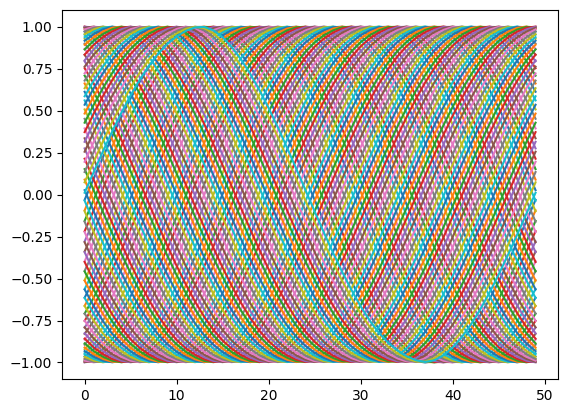

In [ ]:
uinit = np.sin(2 * np.pi * x / L)  # Initial condition
un = uinit

for m in range(20):
  un = un + dt*Dx(un,dx)
  if m%2==0:
    plt.plot(un.detach().numpy())

What we see is that the model looks beautiful for a few timesteps, but is incredibly unstable - all of a sudden it just explodes!

OK - finally we are going to do one little trick, and enforce that the stencil sums to zero, and then rerun.

In [4]:
# Define the model
class FiniteDifferenceOperator(nn.Module):
    def __init__(self,Nleft,Nright,num_layers, hidden_dim):
        super(FiniteDifferenceOperator, self).__init__()
        # Number of total nodes in finite difference stencils
        self.Nstencil = Nleft + Nright + 1
        self.Nleft = Nleft
        self.Nright = Nright

        # The learnable part of the stencil
        self.stencil = torch.nn.Parameter(torch.randn(self.Nstencil))
        # The diffusion parameter. To enforce positivity, we evolve the log of the magnitude
        self.logstabilizer = torch.nn.Parameter(torch.tensor(0.0, dtype=torch.float64))

        # Construct nonlinear network
        # -- The first layer scales up from Nstencil point to a hidden dimension (Input layer)
        # -- Next, hidden layers repeatedly alternate between linear transforms and nonlinear activations (Hidden layers)
        # -- Finally, a linear layer maps back down to Nstencil outputs
        # We'll use skip connections in the hidden layer to improve numerical stability

        layers = []

        # Input layer
        layers.append(nn.Linear(self.Nstencil, hidden_dim, dtype=torch.float64))
        layers.append(nn.Tanh())  # Activation function

        # Hidden layers
        # First make a list of hidden layers
        hiddenlayers = []
        for _ in range(num_layers):
            block = nn.Sequential(
                nn.Linear(hidden_dim, hidden_dim, dtype=torch.float64),
                nn.Tanh()
            )
            hiddenlayers.append(block)

        # Next apply skip connections
        class SkipConnectionBlock(nn.Module):
            def __init__(self, block):
                super(SkipConnectionBlock, self).__init__()
                self.block = block

            def forward(self, x):
                return x + self.block(x)

        skip_connection_layers = [SkipConnectionBlock(block) for block in hiddenlayers]
        hidden_layers = nn.Sequential(*skip_connection_layers)
        layers.extend(hidden_layers)

        # Output layer
        output_layer = nn.Linear(hidden_dim, self.Nstencil, dtype=torch.float64)
        output_layer.weight.data.fill_(0.0)  # Set weights to zero
        output_layer.bias.data.fill_(0.0)  # Set bias to zero (if any)
        layers.append(output_layer)

        self.nonlinear_network = nn.Sequential(*layers)

    def forward(self, x, h):
        # Apply the finite difference stencil to the gridfunction x, assuming periodic BC
        N_nodes = x.shape[0]
        f_out = torch.zeros_like(x)
        for i in range(N_nodes):
          # Wrap indices periodically using the modulo operator (%)
          indices = [(i + j - self.Nleft) % (N_nodes-1) for j in range(self.Nstencil)]

          # Grab solution at indices
          xstencil = x[indices]

          # Hard coded diffusion operator
          D2x = h**(-2)*(x[(i-1)%(N_nodes-1)] - 2*x[i] + x[(i+1)%(N_nodes-1)])

          # Apply neural network to xstencil
          nonlinear_output = self.nonlinear_network(xstencil)

          # Add constraint that sum of stencil coefficient = 0
          nonlinear_output[-1] = -torch.sum(nonlinear_output[:-1])

          # Apply learned stencil to xstencil, including the viscosity term
          # f_out[i] = torch.sum(self.stencil * xstencil) + torch.exp(self.logstabilizer)*D2x
          f_out[i] = torch.sum(nonlinear_output * xstencil) + torch.exp(self.logstabilizer)*D2x

        # Return stencil applied to current state consisting of nonlinearity and stabilizing diffusion
        return f_out

Let's train it up again and see how things have changed...

In [20]:
# Parameters
L = 2.0*np.pi  # Length of the domain
T = np.pi   # Total time
nx = 50  # Number of spatial points
nt = 100  # Number of time steps

# Discretization
dx = L / nx
dt = T / nt
x = torch.from_numpy(np.linspace(0, L, nx))
t = torch.from_numpy(np.linspace(0, T, nt))
Dx = FiniteDifferenceOperator(1,1,2,25)  # Finite difference operator w a neighbor on either side

# Define a single mode
def getData(x,k):
  return torch.sin(k*x)
def getLabel(x,k):
  return (getData(x-dt,k)-getData(x,k))/dt

# Define the optimizer so that it optmizes over stencil parameters
optimizer = optim.Adam(Dx.parameters(), lr=0.005)

num_epochs = 50001
for epoch in range(num_epochs):

    # Clear gradients
    optimizer.zero_grad()

    # Pick a random wavenumber
    k = torch.randint(1, 5, (1,)).item()
    un = getData(x,k)
    Lun = getLabel(x,k)

    # Add small gaussian noise to data
    Lun = Lun + 0.001*torch.randn(Lun.shape)

    dudt_learned = Dx(un,dx)
    loss = torch.mean((Lun-dudt_learned)**2)

    # Backward pass and optimization
    loss.backward(retain_graph=True)
    optimizer.step()


    if epoch % 500 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss}')


Epoch [1/50001], Loss: 45.28718240619059
Epoch [501/50001], Loss: 1.483875810654859
Epoch [1001/50001], Loss: 0.02157351352917038
Epoch [1501/50001], Loss: 0.005851079167305377
Epoch [2001/50001], Loss: 0.0018550221268447053
Epoch [2501/50001], Loss: 0.0006427278609726252
Epoch [3001/50001], Loss: 0.002764864386168272
Epoch [3501/50001], Loss: 0.006405827486839075
Epoch [4001/50001], Loss: 0.003212769975531999
Epoch [4501/50001], Loss: 0.00028480220129656683
Epoch [5001/50001], Loss: 0.005641197327712371
Epoch [5501/50001], Loss: 0.0013247123849228434
Epoch [6001/50001], Loss: 0.00023286715715508603
Epoch [6501/50001], Loss: 0.00022735466039144385
Epoch [7001/50001], Loss: 0.00011272814038437488
Epoch [7501/50001], Loss: 0.0012253886777967243
Epoch [8001/50001], Loss: 3.516600701250695e-05
Epoch [8501/50001], Loss: 9.082014741628686e-05
Epoch [9001/50001], Loss: 2.6935526564910306e-05
Epoch [9501/50001], Loss: 0.0016208598646830093
Epoch [10001/50001], Loss: 4.19649494095358e-05
Epoch 

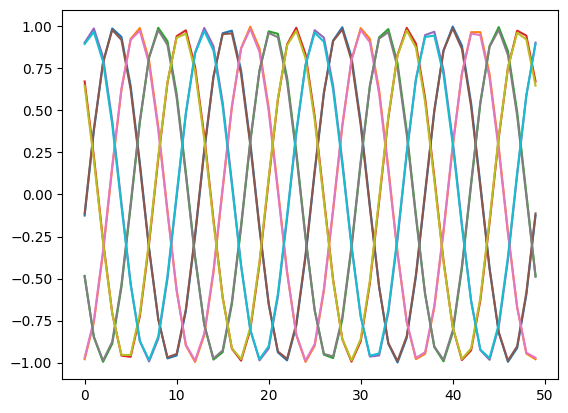

In [21]:
uinit = np.sin(8 * np.pi * x / L)  # Initial condition
un = uinit

for m in range(100):
  un = un + dt*Dx(un,dx)
  if m%10==0:
    plt.plot(un.detach().numpy())